In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import my_funcs as my

random gaussian targets

In [10]:
Ds = [2,10,50,100] #target dimensions 
Cs = [[1,1],[1,10],[0.1,10]] #condition numbers

num_runs = 1

num_iter = 50000
eta = 1e-3

dec = 4

In [11]:
mean_lin = torch.zeros((len(Ds),len(Cs),num_runs))
cov_lin = torch.zeros((len(Ds),len(Cs),num_runs))
mean_gpf = torch.zeros((len(Ds),len(Cs),num_runs))
cov_gpf = torch.zeros((len(Ds),len(Cs),num_runs))

for i,D in enumerate(Ds):
    standard_normal = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D))
    N = D+2
    for k,C in enumerate(Cs):
        for j in range(num_runs):
            m = my.custom_round(standard_normal.sample(),dec)
            S = my.custom_round(my.random_covariance(D,C[0],C[1]),dec)
            p = torch.distributions.MultivariateNormal(m,S)
            x0 = standard_normal.sample([N])

            x = my.svgd(x0,p,kernel = 'linear',eta = eta, num_iter = num_iter)
            mean_lin[i,k,j] = torch.mean((torch.mean(x,0)-p.mean)**2)
            cov_lin[i,k,j] = torch.mean((my.estimate_cov(x) - p.covariance_matrix)**2)

            x = my.gpf(x0,p,eta1 = eta,eta2 = eta, num_iter = num_iter)
            mean_gpf[i,k,j] = torch.mean((torch.mean(x,0)-p.mean)**2)
            cov_gpf[i,k,j] = torch.mean((my.estimate_cov(x) - p.covariance_matrix)**2)
        


torch.Size([4, 1])

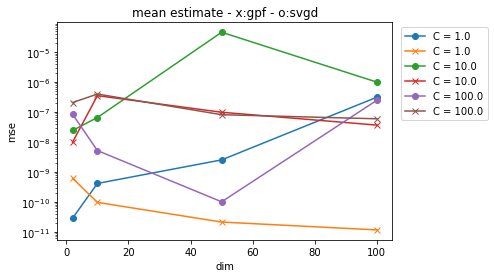

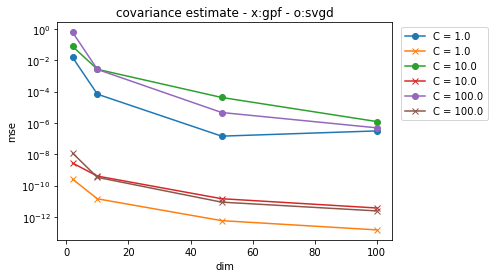

In [58]:
for i in range(3):
    plt.semilogy(Ds,mean_lin[:,i].squeeze()/torch.Tensor(Ds),'-o',label='C = {}'.format(Cs[i][1]/Cs[i][0]))
    plt.semilogy(Ds,mean_gpf[:,i].squeeze()/torch.Tensor(Ds),'-x',label='C = {}'.format(Cs[i][1]/Cs[i][0]))
plt.legend(bbox_to_anchor = [1.3,1.])
plt.xlabel('dim')
plt.ylabel('mse')
plt.title('mean estimate - x:gpf - o:svgd')
plt.show()
for i in range(3):
    plt.semilogy(Ds,cov_lin[:,i].squeeze()/torch.Tensor(Ds),'-o',label='C = {}'.format(Cs[i][1]/Cs[i][0]))
    plt.semilogy(Ds,cov_gpf[:,i].squeeze()/torch.Tensor(Ds),'-x',label='C = {}'.format(Cs[i][1]/Cs[i][0]))
plt.legend(bbox_to_anchor = [1.3,1.])
plt.xlabel('dim')
plt.ylabel('mse')
plt.title('covariance estimate - x:gpf - o:svgd')
plt.show()

with save file structure

In [30]:
Ds = [1,2,10,100]
Ns = [1+d for d in Ds]
num_iters = [1000*d for d in Ds]
eta = 1e-2

num_runs = 10


names = ['linear svgd','rbf svgd','gpf']



In [37]:
data_path = os.path.join(os.getcwd(), 'data')

mse_mean = torch.zeros((num_runs,4,3))
mse_cov = torch.zeros((num_runs,4,3))

for m in np.arange(num_runs):
    for i,D in enumerate(Ds):
        run_name = os.path.join(data_path,'run_{}_dim_{}'.format(m+1,D))

        p = torch.load(os.path.join(run_name,'target'))
        x0 = torch.load(os.path.join(run_name,'x0'))

        x_gpf = torch.load(os.path.join(run_name,'x_gpf'))
        x_lin = torch.load(os.path.join(run_name,'x_lin'))
        x_rbf = torch.load(os.path.join(run_name,'x_rbf'))
        
        for j,x in enumerate([x_lin,x_rbf,x_gpf]):
            mse_mean[m,i,j] = torch.mean((torch.mean(x,0) - p.mean)**2)
            mse_cov[m,i,j] = torch.mean((my.estimate_cov(x) - p.covariance_matrix)**2)


In [39]:
mse_cov

tensor([[[1.3684e+01,        nan, 1.2451e-09],
         [8.3158e-01, 5.2778e+00, 1.3031e-10],
         [1.6986e-02, 1.2289e+00, 1.9865e-11],
         [       nan, 3.1632e-01, 8.2025e-13]],

        [[5.7600e+01,        nan, 1.3133e-09],
         [5.5523e-01, 2.2042e+00, 3.6628e-11],
         [4.0036e-02, 2.9110e+00, 3.8840e-11],
         [       nan, 2.5177e-01, 7.5635e-13]],

        [[1.8881e+01,        nan, 2.4761e-10],
         [1.2011e+00, 3.8974e+00, 5.1159e-13],
         [3.1175e-02, 2.1782e+00, 4.2516e-11],
         [       nan, 2.7332e-01, 7.1465e-13]],

        [[7.7851e-02,        nan, 9.0245e-10],
         [2.4134e+00, 1.2807e+01, 1.2628e-10],
         [2.9567e-02, 2.1017e+00, 2.6833e-11],
         [       nan, 3.3237e-01, 1.0698e-12]],

        [[1.4611e+00,        nan, 1.1141e-11],
         [1.6320e+00, 5.8850e+00, 1.3869e-10],
         [3.3869e-02, 2.4288e+00, 3.5633e-11],
         [       nan, 2.6148e-01, 7.5412e-13]],

        [[6.4390e+00,        nan, 7.3874e-10],
   

Estimates based on trajectories

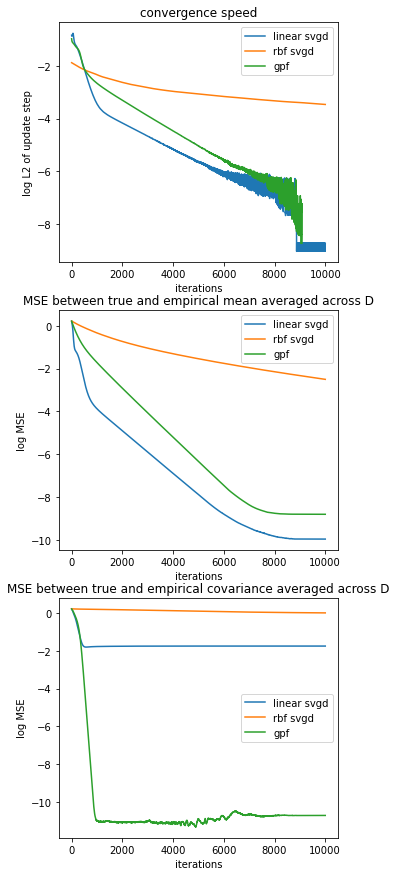

In [12]:
fig,axs = plt.subplots(3,1,figsize=(5,15))

for i,hist in enumerate([x_lin,x_rbf,x_gpf]):
    diff_norm = torch.linalg.norm(hist[1:]-hist[:-1],dim=(1,2))
    mean_hist = torch.mean((p.mean - torch.mean(hist,1))**2,1)
    empirical_covariance = torch.stack([my.estimate_cov(x) for x in hist])
    cov_hist = torch.mean((p.covariance_matrix - empirical_covariance)**2,(1,2))
    
    axs[0].plot(torch.log10(diff_norm),label=names[i])
    axs[1].plot(torch.log10(mean_hist),label=names[i])
    axs[2].plot(torch.log10(cov_hist),label=names[i])
    
axs[0].legend()
axs[0].set_title('convergence speed')
axs[0].set_xlabel('iterations')
axs[0].set_ylabel('log L2 of update step')


axs[1].legend()
axs[1].set_title('MSE between true and empirical mean averaged across D')
axs[1].set_ylabel('log MSE')
axs[1].set_xlabel('iterations')

axs[2].legend()
axs[2].set_title('MSE between true and empirical covariance averaged across D')
axs[2].set_ylabel('log MSE')
axs[2].set_xlabel('iterations')

plt.show()

test individual target

In [39]:
D = 100
#initial distribution q0(x)
q0 = torch.distributions.MultivariateNormal(torch.zeros(D),torch.eye(D))
target_mean = q0.sample()
target_covariance = torch.eye(D)
#target distribution p(x)
p = torch.distributions.MultivariateNormal(target_mean,target_covariance)

#number of particles to sample from q0
N = D+1#2**D 

#samples from g0
x0 = q0.sample([N])

#step size for gpf
eta1 = 1e-2
eta2 = 1e-2
#step size for svgd
eps = 1e-2
#kernel for svgd
names = ['linear','rbf','gpf']

In [54]:
#number of iterations
num_iter = 50000


In [55]:
theta_lin,hist_lin = my.svgd(x0,p,kernel = 'linear',num_iter = num_iter,eps = eps,history = True)

In [56]:
theta_rbf,hist_rbf = my.svgd(x0,p,kernel = 'rbf',num_iter = num_iter,eps = eps,history = True)

In [57]:
gpf_x,hist_gpf = my.gpf(x0,p,num_iter,eta1,eta2,history = True)

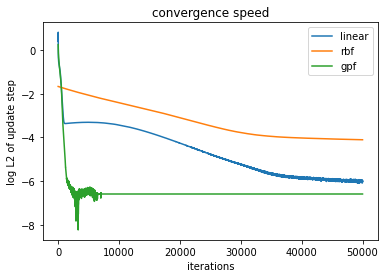

In [58]:
for i,hist in enumerate([hist_lin,hist_rbf,hist_gpf]):
    diff_norm = torch.linalg.norm(hist[1:]-hist[:-1],dim=(1,2))
    plt.plot(torch.log10(diff_norm),label=names[i])
plt.legend()
plt.title('convergence speed')
plt.xlabel('iterations')
plt.ylabel('log L2 of update step')
plt.show()

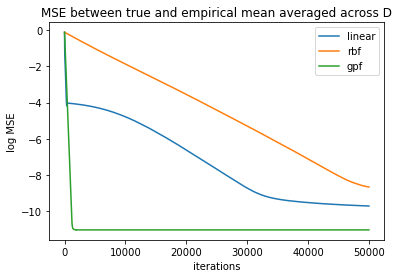

In [59]:
for i,hist in enumerate([hist_lin,hist_rbf,hist_gpf]):
    mean_hist = torch.mean((p.mean - torch.mean(hist,1))**2,1)
    plt.plot(torch.log10(mean_hist),label=names[i])
plt.legend()
plt.title('MSE between true and empirical mean averaged across D')
plt.ylabel('log MSE')
plt.xlabel('iterations')
plt.show()

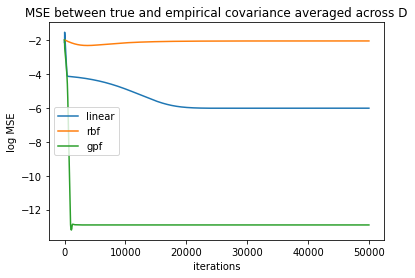

In [60]:
for i,hist in enumerate([hist_lin,hist_rbf,hist_gpf]):
    empirical_covariance = torch.stack([my.estimate_cov(x) for x in hist])
    cov_hist = torch.mean((p.covariance_matrix - empirical_covariance)**2,(1,2))
    plt.plot(torch.log10(cov_hist),label=names[i])
plt.legend()
plt.title('MSE between true and empirical covariance averaged across D')
plt.ylabel('log MSE')
plt.xlabel('iterations')
plt.show()

visualization

In [103]:
a = torch.linspace(0,2*mean_value,100)
x,y = torch.meshgrid(a,a)
z = torch.zeros((100,100))
for i,ai in enumerate(a):
    for j,aj in enumerate(a):
        z[i,j] = torch.exp(p.log_prob(torch.Tensor([ai,aj])))

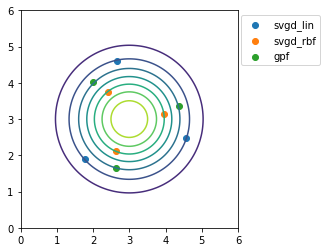

In [104]:
plt.scatter(*theta_lin.T,label='svgd_lin')
plt.scatter(*theta_rbf.T,label='svgd_rbf')
plt.scatter(*gpf_x.T,label='gpf')
plt.contour(x,y,z)
plt.axis('square')
plt.legend(bbox_to_anchor=(1.4,1.0))
plt.show()

evaluation

In [105]:
print('var linear svgd:{}'.format(D*np.mean(np.cov(theta_lin.T))))
print('var rbf svgd:{}'.format(D*np.mean(np.cov(theta_rbf.T))))
print('var gpf:{}'.format(D*np.mean(np.cov(gpf_x.T))))


var linear svgd:2.000293894437571
var rbf svgd:0.6931436282485872
var gpf:1.4999875454936742


In [106]:
print('mean linear svgd:{}'.format(torch.mean(theta_lin.T)))
print('mean rbf svgd:{}'.format(torch.mean(theta_rbf.T)))
print('mean gpf:{}'.format(torch.mean(gpf_x.T)))

mean linear svgd:2.999969482421875
mean rbf svgd:2.9999783039093018
mean gpf:2.999988317489624
